In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import random
random.seed(1100038344)
import survivalstan
import numpy as np
import pandas as pd
from stancache import stancache
from matplotlib import pyplot as plt

INFO:stancache.seed:Setting seed to 1245502385


In [2]:
model_code = survivalstan.models.pem_survival_model_randomwalk

In [3]:
print(model_code)

/*  Variable naming:
 // dimensions
 N          = total number of observations (length of data)
 S          = number of sample ids
 T          = max timepoint (number of timepoint ids)
 M          = number of covariates
 
 // main data matrix (per observed timepoint*record)
 s          = sample id for each obs
 t          = timepoint id for each obs
 event      = integer indicating if there was an event at time t for sample s
 x          = matrix of real-valued covariates at time t for sample n [N, X]
 
 // timepoint-specific data (per timepoint, ordered by timepoint id)
 t_obs      = observed time since origin for each timepoint id (end of period)
 t_dur      = duration of each timepoint period (first diff of t_obs)
 
*/
// Jacqueline Buros Novik <jackinovik@gmail.com>


data {
  // dimensions
  int<lower=1> N;
  int<lower=1> S;
  int<lower=1> T;
  int<lower=0> M;
  
  // data matrix
  int<lower=1, upper=N> s[N];     // sample id
  int<lower=1, upper=T> t[N];     // timepoint id
  int

In [4]:
d = stancache.cached(
    survivalstan.sim.sim_data_exp_correlated,
    N=100,
    censor_time=20,
    rate_form='1 + sex',
    rate_coefs=[-3, 0.5],
)
d['age_centered'] = d['age'] - d['age'].mean()
d.head()

INFO:stancache.stancache:sim_data_exp_correlated: cache_filename set to sim_data_exp_correlated.cached.N_100.censor_time_20.rate_coefs_54462717316.rate_form_1 + sex.pkl


INFO:stancache.stancache:sim_data_exp_correlated: Loading result from cache


,sex,age,rate,true_t,t,event,index,age_centered
0,male,54,0.082085,1.013855,1.013855,True,0,-1.12
1,male,39,0.082085,4.890597,4.890597,True,1,-16.12
2,female,45,0.049787,4.093404,4.093404,True,2,-10.12
3,female,43,0.049787,7.036226,7.036226,True,3,-12.12
4,female,57,0.049787,5.712299,5.712299,True,4,1.88


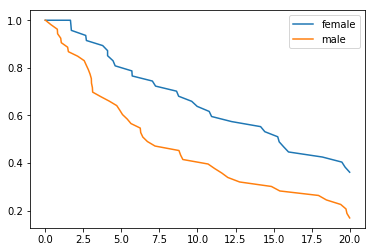

In [5]:
survivalstan.utils.plot_observed_survival(df=d[d['sex']=='female'], event_col='event', time_col='t', label='female')
survivalstan.utils.plot_observed_survival(df=d[d['sex']=='male'], event_col='event', time_col='t', label='male')
plt.legend()

In [6]:
dlong = stancache.cached(
    survivalstan.prep_data_long_surv,
    df=d, event_col='event', time_col='t'
)

INFO:stancache.stancache:prep_data_long_surv: cache_filename set to prep_data_long_surv.cached.df_14209590808.event_col_event.time_col_t.pkl


INFO:stancache.stancache:prep_data_long_surv: Loading result from cache


In [7]:
dlong.head()

,sex,age,rate,true_t,t,event,index,age_centered,end_time,end_failure
0,male,54,0.082085,1.013855,1.013855,True,0,-1.12,1.013855,True
58,male,54,0.082085,1.013855,1.013855,True,0,-1.12,0.808987,False
65,male,54,0.082085,1.013855,1.013855,True,0,-1.12,0.377535,False
72,male,54,0.082085,1.013855,1.013855,True,0,-1.12,0.791192,False
73,male,54,0.082085,1.013855,1.013855,True,0,-1.12,0.009787,False


In [8]:
testfit = survivalstan.fit_stan_survival_model(
    model_cohort = 'test model',
    model_code = model_code,
    df = dlong,
    sample_col = 'index',
    timepoint_end_col = 'end_time',
    event_col = 'end_failure',
    formula = '~ age_centered + sex',
    iter = 5000,
    chains = 4,
    seed = 9001,
    FIT_FUN = stancache.cached_stan_fit,
    )


INFO:stancache.stancache:Step 1: Get compiled model code, possibly from cache


INFO:stancache.stancache:StanModel: cache_filename set to anon_model.cython_0_29_2.model_code_17281568671805165521.pystan_2_18_1_0.stanmodel.pkl


INFO:stancache.stancache:StanModel: Loading result from cache


INFO:stancache.stancache:Step 2: Get posterior draws from model, possibly from cache


INFO:stancache.stancache:sampling: cache_filename set to anon_model.cython_0_29_2.model_code_17281568671805165521.pystan_2_18_1_0.stanfit.chains_4.data_75284643319.iter_5000.seed_9001.pkl


INFO:stancache.stancache:sampling: Loading result from cache


In [9]:
survivalstan.utils.print_stan_summary([testfit], pars='lp__')

            mean   se_mean         sd        2.5%        50%       97.5%      Rhat
lp__ -287.781216  1.521948  25.841239 -337.843663 -288.32069 -236.827395  1.006161


In [10]:
survivalstan.utils.print_stan_summary([testfit], pars='log_baseline_raw')

                          mean   se_mean        sd      2.5%       50%     97.5%      Rhat
log_baseline_raw[1]  -2.266052  0.022797  0.757871 -3.781383 -2.264353 -0.801449  1.002332
log_baseline_raw[2]  -2.364431  0.022200  0.747522 -3.852205 -2.352824 -0.913209  1.002224
log_baseline_raw[3]  -2.469519  0.022284  0.742275 -3.943979 -2.457068 -1.035849  1.001857
log_baseline_raw[4]  -2.566836  0.022849  0.744848 -4.040161 -2.548941 -1.108471  1.001946
log_baseline_raw[5]  -2.662735  0.023252  0.749227 -4.152525 -2.639411 -1.206405  1.001873
log_baseline_raw[6]  -2.754253  0.024026  0.759507 -4.251543 -2.735682 -1.266185  1.001951
log_baseline_raw[7]  -2.843475  0.024597  0.768474 -4.378099 -2.824548 -1.343800  1.001972
log_baseline_raw[8]  -2.924604  0.025082  0.776434 -4.479474 -2.907346 -1.419350  1.002177
log_baseline_raw[9]  -3.003173  0.025526  0.782436 -4.581052 -2.986473 -1.474753  1.002179
log_baseline_raw[10] -3.073193  0.026218  0.791575 -4.648971 -3.066341 -1.511074  1.002226

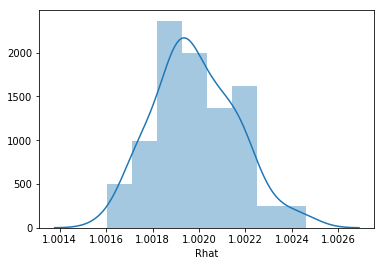

In [11]:
survivalstan.utils.plot_stan_summary([testfit], pars='log_baseline_raw')

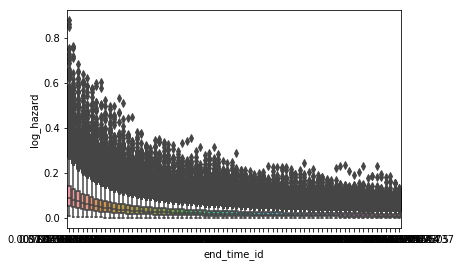

In [12]:
survivalstan.utils.plot_coefs([testfit], element='baseline')

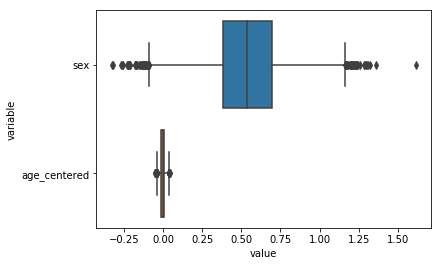

In [13]:
survivalstan.utils.plot_coefs([testfit])

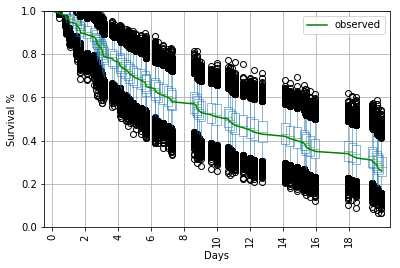

In [14]:
survivalstan.utils.plot_pp_survival([testfit], fill=False)
survivalstan.utils.plot_observed_survival(df=d, event_col='event', time_col='t', color='green', label='observed')
plt.legend()

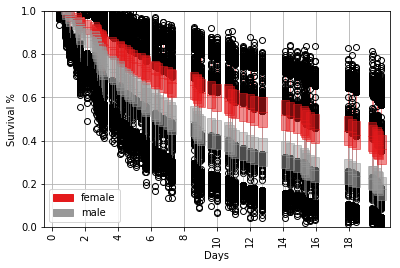

In [15]:
survivalstan.utils.plot_pp_survival([testfit], by='sex')